# Introduction to MLE
---
## Overview
We will be looking at parameter estimation in this notebook. In particular, we will be:
- Defining distributions
- Plotting likelihood functions
- Estimating parameters
- Comparing numerical methods (that estimate parameters even in the absence of a closed-form solution)

In [1]:
import pandas as pd
import seaborn as sns
import scipy
import itertools

import autograd.numpy as np # We will be using autograd's extended np
import matplotlib.pyplot as plt

from autograd import jacobian
from autograd import hessian

from src.tobit import Tobit
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,9)})

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# 1. Distributions and likelihood functions

## MLE:
- We will be using `scipy`: a Python library for scientific computing. 
- `scipy` was introduced in the previous notebook on limited binary outcomes. `scipy` was used to implement Tobit from scratch.
- Do not worry if you had difficulty understanding the Tobit implementation! 
- The examples in this notebook are a lot more straightforward than the Tobit example, which required us to specify a piece-wise likelihood function. We will revisit the Tobit implementation at the end of this notebook.

## 1.1 Normal distribution
- Recall that the general form of the Gaussian probability distribution function (PDF) is given by:

$$ {\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}} $$

In [3]:
# 1. Let's define the pdf of the Normal distribution from scratch

def gaussian_pdf(mu: float,
                 sigma: float,
                 x: float) -> float:
    """Given mu, sigma, and a single observation x, 
    return the value of the Gaussian pdf.
    """
    mu.astype(float)
    sigma.astype(float)
    x.astype(float)
    sigma_2 = sigma**2
    pi = scipy.pi
    a1 = (sigma_2*2*pi)**-(1/2)
    a2 = -1/(2*sigma_2)*(x-mu)**2
    y = a1*np.exp(a2)
    return y


# 2. Let's define the likelihood and log-likelihood

def gaussian_likelihood(params, pdf, X, ll=False, neg=False):
    """Given params (mu, sigma), a Gaussian pdf, and a 
    vector X of observations, return the value of the Gaussian 
    likelihood function.
    
    Note: if ll=True, returns the log-likelihood value.
    Note: if neg=True, returns negative value (only effective if ll=True)
    """
    def _pdf(mu, sigma, ll):
        """Converts the pdf function into a sequence of
        functions, where the inner-most function takes a 
        single argument x.

        This design pattern is called "currying".
        """
        def _pdf_x(x):
            val = pdf(mu, sigma, x)
            if ll:
                # If likelihood value not equal 0
                if abs(val) > 0:
                    val = np.log(pdf(mu, sigma, x))
                else:
                    val = 0
            return val
        return _pdf_x
    
    mu, sigma = params[0], params[1]
    
    # Map X to the pdf / log-pdf function
    val_seq = np.array(list(map(_pdf(mu, sigma, ll), X)))   
    
    # If likelihood
    if not(ll):
        # Apply the PRODUCT operator
        value = np.prod(val_seq)
    # If log-likelihood
    else:
        # Apply SUMMATION
        value = sum(val_seq)
        if neg:
            value = -value
    return value

## 1.2 Bernoulli distribution
- Recall that the general form of the Bernoulli probability mass function (PMF) is given by:

$$ {\displaystyle f(x;p)= p^{x}(1-p)^{1-x}} $$ 

In [4]:
# 1. Let's define the Bernoulli distribution

def bernoulli_pmf(p: float, x: int) -> float:
    """Given probability of success p and a single observation x, 
    return the value of the Bernoulli pmf.
    """
    y = p**x*(1-p)**(1-x)
    return y
    

# 2. Let's define the likelihood and log-likelihood

def bernoulli_likelihood(p, pmf, X, ll=False, neg=False):
    """Given p, Bernoulli pmf, and a 
    vector X of observations, return the value of the Gaussian 
    likelihood function.
    
    Note: if ll=True, returns the log-likelihood value.
    Note: if neg=True, returns negative value (only effective if ll=True)
    """
    def _pmf(p, ll):
        """Converts the pmf function into a sequence of
        functions, where the inner-most function takes a 
        single argument x.

        This design pattern is called "currying".
        """
        def _pmf_x(x):
            val = pmf(p, x)
            if ll:
                # If likelihood value not equal 0
                if abs(val) > 0:
                    val = np.log(pmf(p, x))
                else:
                    val = 0
            return val
        return _pmf_x

    # Map X to the pdf / log-pdf function
    val_seq = np.array(list(map(_pmf(p, ll), X)))   
    
    # If likelihood
    if not(ll):
        # Apply the PRODUCT operator
        value = np.prod(val_seq)
    # If log-likelihood
    else:
        # Apply SUMMATION
        value = sum(val_seq)
        if neg:
            value = -value
    return value

# 2. Plotting likelihoods

## 2.1 Normal distribution

In [5]:
# Let create a sample of size N=50 that is drawn from a normal distribution 
# with mean = 0 and sigma = 1

mu, sigma, N = 0, 1, 50
X_normal = np.random.normal(mu, sigma, N)

In [6]:
# Let's plot the gaussian likelihood on a 3D plane (likelihood value, mu, sigma)
# by defining a range of possible mu and sigma values.
# Use numpy's linspace function to create an array of decimal step values

mu_range = np.linspace(-1, 1, num=100)
sigma_range = np.linspace(0.05, 4.5, num=100)

In [7]:
# Calculate likelihood values

# 1. Compute the Cartesian product of mu_range and sigma_range
mu_sigma_seq = list(itertools.product(mu_range, sigma_range))

# 2. Apply gaussian_likelihood in a list comprehension over sequence from 1.
# 2.1 Likelihood
likelihood_val_seq = [gaussian_likelihood((mu, sigma),
                                          gaussian_pdf,
                                          X_normal,
                                          ll=False)
                      for mu, sigma in mu_sigma_seq]

# 2.2. Log-likliehood
log_likelihood_val_seq = [gaussian_likelihood((mu, sigma),
                                              gaussian_pdf,
                                              X_normal,
                                              ll=True)
                          for mu, sigma in mu_sigma_seq]

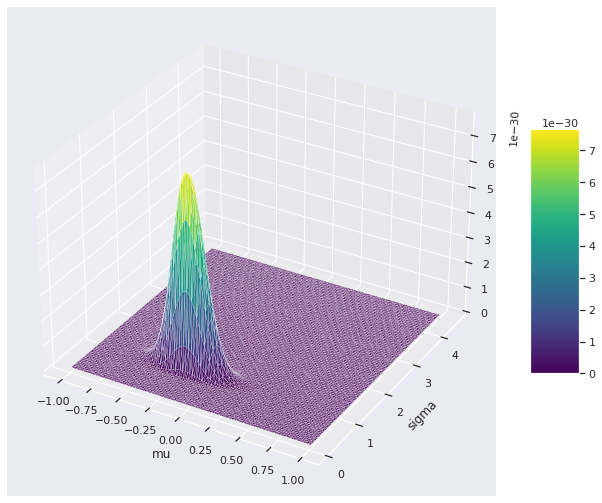

In [8]:
# Plot Gaussian likelihood function as a contour plot

x, y = zip(*mu_sigma_seq)
z = likelihood_val_seq

# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)

ax.set_xlabel('mu')
ax.set_ylabel('sigma')
 
# Add a color bar which maps values to colors.
surf = ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)

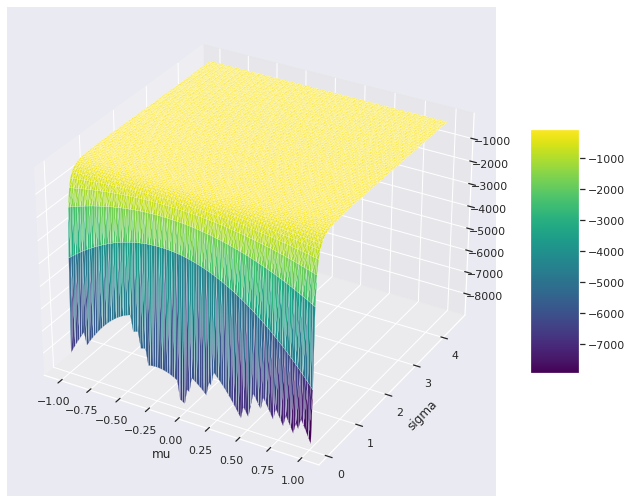

In [9]:
# Plot Gaussian log-likelihood function as a contour plot

x, y = zip(*list(itertools.product(mu_range, sigma_range)))
z = log_likelihood_val_seq

# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)

ax.set_xlabel('mu')
ax.set_ylabel('sigma')
 
# Add a color bar which maps values to colors.
surf = ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)

## 2.2. Bernoulli distribution

In [10]:
# Let create two samples of size N=5 that is drawn from a Bernoulli distribution
# with p_1 = 0 and p_2 = 1 

N = 5
X_bernoulli_1 = [0]*N
X_bernoulli_2 = [1]*N

In [11]:
# 1. Get sequence of probability of success values
prob_vals = np.linspace(0, 1, 10) 

# 2. Apply bernoulli_likelihood in a list comprehension over sequence from 1.
# 2.1 Likelihood
likelihood_val_seq_1 = [bernoulli_likelihood(p,
                                             bernoulli_pmf,
                                             X_bernoulli_1)
                        for p in prob_vals]


likelihood_val_seq_2 = [bernoulli_likelihood(p,
                                             bernoulli_pmf,
                                             X_bernoulli_2)
                        for p in prob_vals]


# 2.2 log likelihood
log_likelihood_val_seq_1 = [bernoulli_likelihood(p,
                                                 bernoulli_pmf,
                                                 X_bernoulli_1,
                                                 ll=True)
                            for p in prob_vals]

log_likelihood_val_seq_2 = [bernoulli_likelihood(p,
                                                 bernoulli_pmf,
                                                 X_bernoulli_2,
                                                 ll=True)
                            for p in prob_vals]

[Text(0.5, 0, 'Probability of success'),
 Text(0, 0.5, 'Likelihood value'),
 Text(0.5, 1.0, 'prob = 1')]

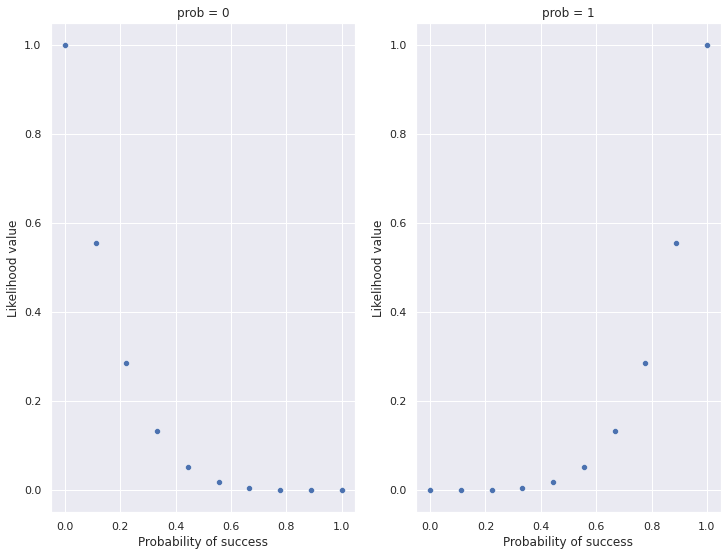

In [12]:
# Plot Bernoulli likelihoods

fig, axes = plt.subplots(1, 2)
sc1 = sns.scatterplot(ax=axes[0], x=prob_vals, y=likelihood_val_seq_1)
sc2 = sns.scatterplot(ax=axes[1], x=prob_vals, y=likelihood_val_seq_2)

axes[0].set(xlabel='Probability of success', ylabel='Likelihood value', title='prob = 0')
axes[1].set(xlabel='Probability of success', ylabel='Likelihood value', title='prob = 1')

[Text(0.5, 0, 'Probability of success'),
 Text(0, 0.5, 'Log-likelihood value'),
 Text(0.5, 1.0, 'prob = 1')]

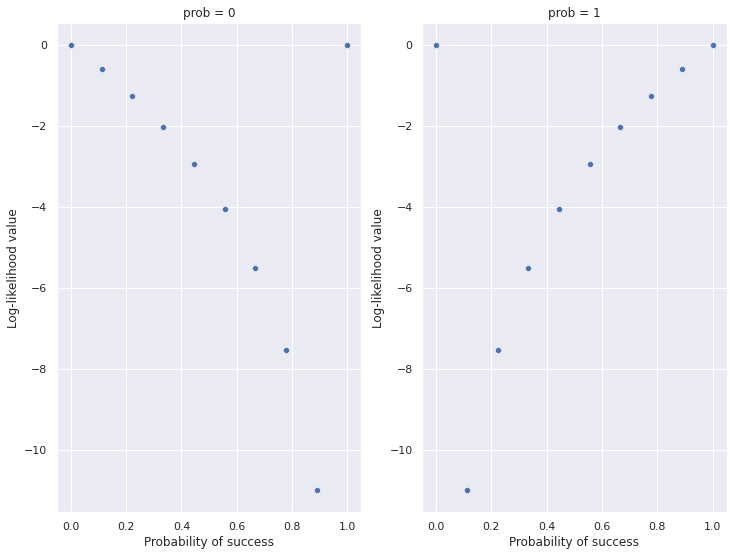

In [13]:
# Plot Bernoulli log-likelihoods

fig, axes = plt.subplots(1, 2)
sc1 = sns.scatterplot(ax=axes[0], x=prob_vals, y=log_likelihood_val_seq_1)
sc2 = sns.scatterplot(ax=axes[1], x=prob_vals, y=log_likelihood_val_seq_2)

# You can't take log(0), hence two 0 "maximum" values at the end points
# In the bernoulli_likelihood function, I set log-likelihood to 0 if the likelihood is 0
# Pls fix?

axes[0].set(xlabel='Probability of success', ylabel='Log-likelihood value', title='prob = 0')
axes[1].set(xlabel='Probability of success', ylabel='Log-likelihood value', title='prob = 1')

# 3. Numerical optimisation in Python
- `scipy` only has a minimiser.
- Documentation for `scipy`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
- Therefore, we need to use negative likelihoods / negative log-likelihoods. This logic was implemented in the likelihood Python functions.
- Let's perform MLE using numerical methods on the normally distributed random sample.

In [14]:
# Let create a sample of size N=50 that is drawn from a normal distribution 
# with mean = 0 and sigma = 1

mu, sigma, N = 0, 1, 50
X_normal = np.random.normal(mu, sigma, N)

In [15]:
# Let's define our sensitivity plan
# We will build a sensitivity plan grid to test
# every combination of hyperparameters.

SENSITIVITY_PLAN = {
    'x0': [(-5, 10), (-5, 500)], # starting values (mu, sigma)
    'method': ['Nelder-Mead',
               'BFGS',
               'CG'] # methods
}

In [16]:
# Let's use nested for loops to search through the two hyperparameters 
# But can you think of a faster, more concise, and scalable (to multiple hyperparameters)
# implementation using the map-reduce approach?

hyperparams = []
results = []
for x0 in SENSITIVITY_PLAN['x0']:
    for method in SENSITIVITY_PLAN['method']:
        result = scipy.optimize.minimize(fun=gaussian_likelihood,
                                         x0=np.asarray(x0), # Starting values as ndarray
                                         args=(gaussian_pdf,
                                               X_normal,
                                               True,
                                               True), # Fixed parameters to specify the negative log-likelihood function
                                         method=method)
        hyperparams.append(f'{x0} and {method}')
        results.append(result)

In [17]:
# Note that scipy.optimize.minimize returns a Dictionary with optimization results 
# and meta-information

results[0]

 final_simplex: (array([[0.01775552, 0.86555518],
       [0.01782545, 0.86554609],
       [0.01771735, 0.86550686]]), array([63.72670236, 63.72670239, 63.72670251]))
           fun: 63.72670235830173
       message: 'Optimization terminated successfully.'
          nfev: 98
           nit: 53
        status: 0
       success: True
             x: array([0.01775552, 0.86555518])

In [18]:
# Compare results

sensitivity_test = pd.DataFrame({
    'hyperparams': hyperparams,
    'mu': [r.x[0] for r in results],
    'sigma': [r.x[1] for r in results],
}).set_index('hyperparams')
sensitivity_test

,mu,sigma
hyperparams,,
"(-5, 10) and Nelder-Mead",0.017756,0.865555
"(-5, 10) and BFGS",0.017781,0.865538
"(-5, 10) and CG",0.017781,0.865538
"(-5, 500) and Nelder-Mead",0.017818,-0.865561
"(-5, 500) and BFGS",0.017781,0.865538
"(-5, 500) and CG",0.017781,0.865538


### Note:
- To approximate the standard errors, we will be using the Autograd library.
- The code below follows https://rlhick.people.wm.edu/posts/mle-autograd.html

In [19]:
# Let approximate the standard errors

args = (gaussian_pdf, X_normal, True, True)
jacobian_ = jacobian(gaussian_likelihood) # Define the Jacobian using the autograd library
hessian_ = hessian(gaussian_likelihood) # Define the Hessian using the autograd library

result = scipy.optimize.minimize(fun=gaussian_likelihood,
                                 x0=np.asarray([-5, 10]), # Starting values as ndarray
                                 args=args, # Fixed parameters to specify the negative log-likelihood function
                                 method='BFGS',
                                 jac=jacobian_)

information = np.transpose(hessian_(result.x, *args)) # Information matrix
se = np.sqrt(np.diagonal(np.linalg.inv(information))) # Square root of the diagonal of the inverse Hessian
print('mu SE = {}\nsigma SE = {}'.format(se[0], se[1]))

mu SE = 0.12240549800047461
sigma SE = 0.08655375742927807


# 4. Tobit revisited

## Load data and data prep

In [20]:
# Load data

mroz_data = pd.read_csv('http://www.principlesofeconometrics.com/poe5/data/csv/mroz.csv')
mroz_data = mroz_data[['hours', 'educ', 'exper', 'age', 'kidsl6']] # Select relevant columns

In [21]:
# Create column of 'cutoff' indicator variables
# 0 if 'hours' == 0, 1 otherwise
cutoff = mroz_data['hours'].apply(lambda x: 0 if x == 0 else 1)
cutoff.name = 'cutoff'

# Add cutoff to data and set as index
mroz_data = mroz_data.merge(cutoff, left_index=True, right_index=True).set_index('cutoff')

# Exog and endog
endog = mroz_data['hours']
exog = mroz_data[['educ', 'exper', 'age', 'kidsl6']]

# Add intercept to exog
exog['intecept'] = 1

## Sensitivity
- As you notice, the Tobit log-likelihood function seems to be poorly behaved.
- The numerical optimisation algorithms do not seem to converge to a maximum point, let alone a common point across them.

In [22]:
SENSITIVITY_PLAN = {
    'method': ['Nelder-Mead',
               'BFGS',
               'CG'] # methods
}

In [23]:
# Create Tobit instance
tobit_mod = Tobit(endog, exog)

hyperparams = []
results = []
for method in SENSITIVITY_PLAN['method']:
    # Fit model using a random starting point (with seed = 42)
    tobit_res = tobit_mod.fit(method=method)
    hyperparams.append(method)
    results.append(tobit_res)

         Current function value: nan
         Iterations: 2
         Function evaluations: 791
         Gradient evaluations: 113
         Current function value: 3457.919606
         Iterations: 100
         Function evaluations: 1589
         Gradient evaluations: 227


In [24]:
# Compare results

sensitivity_test = pd.DataFrame({
    'hyperparams': hyperparams,
})

# Transposed and concantenated results
transposed_res = pd.concat([res.set_index('estimate').T
                            for res in results]).reset_index(drop=True)
sensitivity_test = sensitivity_test.merge(transposed_res,
                                          right_index=True,
                                          left_index=True)
sensitivity_test

,hyperparams,educ,exper,age,kidsl6,intecept,sd
0,Nelder-Mead,1.926230,-5.815772,36.959267,-275.531145,-49.926324,24.988442
1,BFGS,61311.837055,35725.962139,197009.708472,721.910533,4968.853033,-4728.601494
2,CG,21.506902,20.690953,4.660187,-70.289085,610.998376,718.192438
